Extract frames from a movie and convert to FITS files

frame at  4.0


<IPython.core.display.Javascript object>


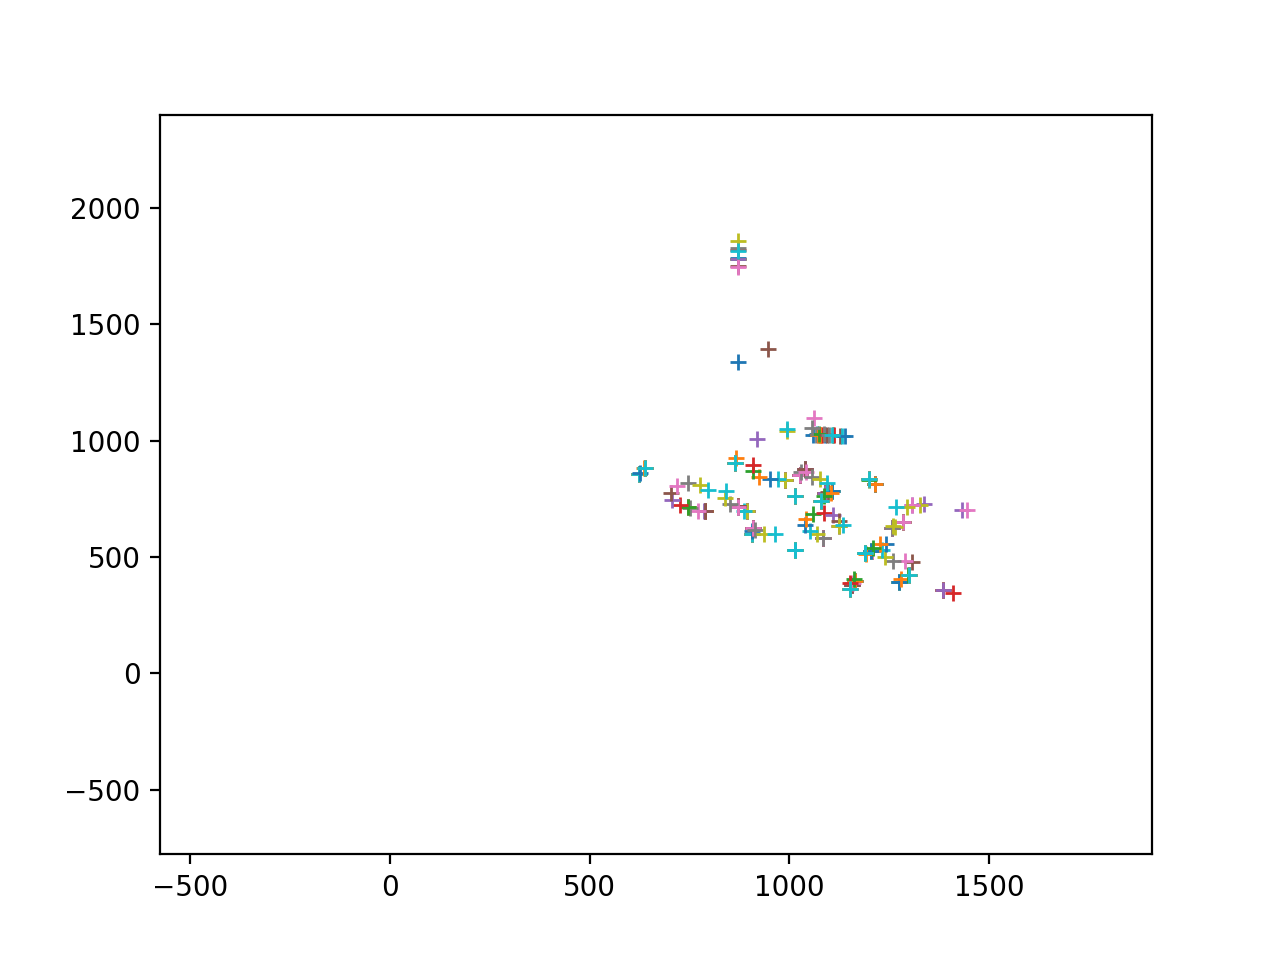

frame at  4.2
frame at  4.4
frame at  4.6
frame at  4.8
frame at  5.0
frame at  5.2
frame at  5.4
frame at  5.6
frame at  5.8
frame at  6.0
frame at  6.2
frame at  6.4
frame at  6.6
frame at  6.800000000000001
frame at  7.0
frame at  7.2
frame at  7.4
frame at  7.6
frame at  7.800000000000001


In [1]:
%matplotlib notebook
from moviepy.editor import *
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from msgfitter import fitgaussian
import mahotas as mh
from scipy.ndimage.measurements import center_of_mass

def remove_hot_pixels(image,nsigma=5):
	"""
	Remove isolated hot pixels in the image. The mean value of the original image is
	calculated and a mean + nsigma threshold cut is applied. Hot pixels receive a new value of
	the average of their 4 next neighbors.
	"""
	im_mean=np.mean(image)
	im_sig=np.std(image)
	hot_thresh=im_mean+nsigma*im_sig

	hp_img = np.copy(image)
	hp_img = hp_img.astype(np.uint32)
	low_values_indices = hp_img < hot_thresh  # Where values are low
	
	hp_img[low_values_indices] = 0
	ind = zip(*np.where(hp_img > hot_thresh))
	xlimit=len(hp_img[0])
	ylimit=len(hp_img)
		
	for i in ind:
		if i[0] == 0 or i[0]==ylimit-1 or i[1]==0 or i[1]==xlimit-1:
			print('Edge hot spot')
			image[i[0],i[1]] =np.median(image)
		else:
			neighborsum=hp_img[i[0]+1,i[1]] + hp_img[i[0]-1,i[1]] + hp_img[i[0],i[1]-1] + hp_img[i[0],i[1]+1]
			if neighborsum == 0:
				image[i[0],i[1]] = (image[i[0]+1,i[1]]+image[i[0]-1,i[1]]+image[i[0],i[1]-1]+image[i[0],i[1]+1])/4.
	del hp_img        
	return image
def im2bw(image,level):
	# M.Schubnell - faking the matlab im2bw function
	s = np.shape(image)
	bw=np.zeros(s,dtype=int)
	threshold_indices = image > level
	bw[threshold_indices] = 1
	return bw


video = VideoFileClip("/Users/michael/Downloads/movie.mp4")

for r in range (20):
    frametime=4.+.2*r
    print('frame at ',frametime)
    frame=video.get_frame(frametime)
    r_data=frame[:,:,0]
    g_data=frame[:,:,1]
    b_data=frame[:,:,2]

    img=r_data.astype('uint16')+g_data.astype('uint16')+b_data.astype('uint16')

    img[img<0]=0
    mg=remove_hot_pixels(img,7)
    no_otsu=True
    level_fraction_of_peak = 0.8
    level_frac = int(level_fraction_of_peak*np.max(np.max(img)))
    if no_otsu:
        level = level_frac
    else:
        level_otsu = mh.thresholding.otsu(img)
        level = max(level_otsu,level_frac)
    bw=im2bw(img,level)


    n_centroids_to_keep=20
    labeled, nr_objects = mh.label(bw)
    sizes = mh.labeled.labeled_size(labeled) # size[0] is the background size, sizes[1 and greater] are number of pixels in each region
    sorted_sizes_indexes = np.argsort(sizes)[::-1] # return in descending order
    good_spot_indexes = sorted_sizes_indexes[1:n_centroids_to_keep+1] # avoiding the background regions entry at the beginning

    FWHMSub = []
    xCenSub = []
    yCenSub = []        
    peaks = []
    fluxes=[]
    centers = center_of_mass(labeled, labels=labeled, index=[good_spot_indexes])


    nbox = 25
    for i,x in enumerate(centers):
        x=x[0]
        px=int(round(x[1]))
        py=int(round(x[0]))     
        data = img[py-nbox:py+nbox,px-nbox:px+nbox]
        params = fitgaussian(data)
        fwhm=abs(2.355*max(params[4],params[5]))
        if fwhm < .5:
            print(" fit failed - trying again with smaller fitbox")
            sbox=nbox-1
            data = img[py-sbox:py+sbox,px-sbox:px+sbox]
            params = fitgaussian(data)
            fwhm=abs(2.355*max(params[4],params[5]))
        xCenSub.append(float(px)-float(nbox)+params[3])
        yCenSub.append(float(py)-float(nbox)+params[2])
        FWHMSub.append(fwhm)

        peak = params[1]
        peaks.append(peak)

    sindex=sorted(range(len(peaks)), key=lambda k: peaks[k])

    peaks_sorted=[peaks[i] for i in sindex]
    x_sorted=[xCenSub[i] for i in sindex]
    y_sorted=[yCenSub[i] for i in sindex]
    fwhm_sorted=[FWHMSub[i] for i in sindex]

    plt.plot(x_sorted,y_sorted,'+')


In [26]:
import numpy as np
import mahotas as mh
import astropy.io.fits
from astropy.io import fits
from scipy.ndimage.measurements import center_of_mass
fname='/Users/michael/Downloads/all.fits'
img=fits.getdata(fname)
def remove_hot_pixels(image,nsigma=5):
	"""
	Remove isolated hot pixels in the image. The mean value of the original image is
	calculated and a mean + nsigma threshold cut is applied. Hot pixels receive a new value of
	the average of their 4 next neighbors.
	"""
	im_mean=np.mean(image)
	im_sig=np.std(image)
	hot_thresh=im_mean+nsigma*im_sig

	hp_img = np.copy(image)
	hp_img = hp_img.astype(np.uint32)
	low_values_indices = hp_img < hot_thresh  # Where values are low
	
	hp_img[low_values_indices] = 0
	ind = zip(*np.where(hp_img > hot_thresh))
	xlimit=len(hp_img[0])
	ylimit=len(hp_img)
		
	for i in ind:
		if i[0] == 0 or i[0]==ylimit-1 or i[1]==0 or i[1]==xlimit-1:
			print('Edge hot spot')
			image[i[0],i[1]] =np.median(image)
		else:
			neighborsum=hp_img[i[0]+1,i[1]] + hp_img[i[0]-1,i[1]] + hp_img[i[0],i[1]-1] + hp_img[i[0],i[1]+1]
			if neighborsum == 0:
				image[i[0],i[1]] = (image[i[0]+1,i[1]]+image[i[0]-1,i[1]]+image[i[0],i[1]-1]+image[i[0],i[1]+1])/4.
	del hp_img        
	return image
def im2bw(image,level):
	# M.Schubnell - faking the matlab im2bw function
	s = np.shape(image)
	bw=np.zeros(s,dtype=int)
	threshold_indices = image > level
	bw[threshold_indices] = 1
	return bw

img[img<0]=0
mg=remove_hot_pixels(img,7)
no_otsu=True
level_fraction_of_peak = 0.8
level_frac = int(level_fraction_of_peak*np.max(np.max(img)))
if no_otsu:
    level = level_frac
else:
    level_otsu = mh.thresholding.otsu(img)
    level = max(level_otsu,level_frac)
bw=im2bw(img,level)

#bwf=fits.PrimaryHDU(data=bw)
#bwf.writeto('bw.fits')
n_centroids_to_keep=30
labeled, nr_objects = mh.label(bw)
sizes = mh.labeled.labeled_size(labeled) # size[0] is the background size, sizes[1 and greater] are number of pixels in each region
sorted_sizes_indexes = np.argsort(sizes)[::-1] # return in descending order
good_spot_indexes = sorted_sizes_indexes[1:n_centroids_to_keep+1] # avoiding the background regions entry at the beginning

FWHMSub = []
xCenSub = []
yCenSub = []        
peaks = []
fluxes=[]
centers = center_of_mass(labeled, labels=labeled, index=[good_spot_indexes])


nbox = 20
for i,x in enumerate(centers):
    x=x[0]
    px=int(round(x[1]))
    py=int(round(x[0]))     
    data = img[py-nbox:py+nbox,px-nbox:px+nbox]
    params = fitgaussian(data)
    fwhm=abs(2.355*max(params[4],params[5]))
    if fwhm < .5:
        print(" fit failed - trying again with smaller fitbox")
        sbox=nbox-1
        data = img[py-sbox:py+sbox,px-sbox:px+sbox]
        params = fitgaussian(data)
        fwhm=abs(2.355*max(params[4],params[5]))
    xCenSub.append(float(px)-float(nbox)+params[3])
    yCenSub.append(float(py)-float(nbox)+params[2])
    FWHMSub.append(fwhm)

    #flux=np.sum(data)-len(data)*dbias
    #print("***",flux,dbias*len(data))
    #fluxes.append(flux)
    peak = params[1]
    peaks.append(peak)

sindex=sorted(range(len(peaks)), key=lambda k: peaks[k])

peaks_sorted=[peaks[i] for i in sindex]
x_sorted=[xCenSub[i] for i in sindex]
y_sorted=[yCenSub[i] for i in sindex]
fwhm_sorted=[FWHMSub[i] for i in sindex]

#return xCenSub, yCenSub, peaks, FWHMSub, fluxes, filename
with open('region.reg','w') as fp:
    for i, x in enumerate(x_sorted):
        #print("{:5d} {:9.3f} {:9.3f} {:7.3f}   {:9.3f} {:9.3f}   {:7.3f} ".format(i, x, yCenSub[i], FWHMSub[i], peaks[i], bias[i],magnitude(peaks[i],bias[i])))
        fp.write('circle '+ "{:9.3f} {:9.3f} {:7.3f} \n".format(x+1, y_sorted[i]+1, fwhm_sorted[i]/2.))
        text='"'+str(i)+'"'
        fp.write('text '+ "{:9.3f} {:9.3f} {:s} \n".format(x+1+5, y_sorted[i]+1+5, text))

print('done')

/opt/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


done


In [24]:
print(xCenSub)

[624.42791166433301, 787.71149838956887, 866.29246185058628, 893.51727702743597, 1027.0817967187884, 1014.2819268966775, 905.60062282061335, 989.49875961387409, 1083.2202952654095, 1097.0354186963013, 1214.8609420213154, 1013.4760718839468, 1013.257843392072, 1156.8914421656677, 1205.5731250914657, 1688.2571848425948, 1274.3786873154943, 1308.0986726206052, 1283.6153155560521, 1441.8530254355658, 1432.1100361399247, 1337.2254341367543, 1713.3003683877125, 1383.4713510693982, 1459.7736226321663]


In [1]:
import numpy as np
import mahotas as mh
#from pylab import imshow, show
import pyfits
from msgfitter import fitgaussian
from scipy.ndimage.measurements import center_of_mass

import os


def darkbias(image):
	db=np.mean(image[0:500,5450:5950])
	return db

def remove_hot_pixels(image,nsigma=5):
	"""
	Remove isolated hot pixels in the image. The mean value of the original image is
	calculated and a mean + nsigma threshold cut is applied. Hot pixels receive a new value of
	the average of their 4 next neighbors.
	"""
	im_mean=np.mean(image)
	im_sig=np.std(image)
	hot_thresh=im_mean+nsigma*im_sig

	hp_img = np.copy(image)
	hp_img = hp_img.astype(np.uint32)
	low_values_indices = hp_img < hot_thresh  # Where values are low
	
	hp_img[low_values_indices] = 0
	ind = zip(*np.where(hp_img > hot_thresh))
	xlimit=len(hp_img[0])
	ylimit=len(hp_img)
		
	for i in ind:
		if i[0] == 0 or i[0]==ylimit-1 or i[1]==0 or i[1]==xlimit-1:
			print('Edge hot spot')
			image[i[0],i[1]] =np.median(image)
		else:
			neighborsum=hp_img[i[0]+1,i[1]] + hp_img[i[0]-1,i[1]] + hp_img[i[0],i[1]-1] + hp_img[i[0],i[1]+1]
			if neighborsum == 0:
				image[i[0],i[1]] = (image[i[0]+1,i[1]]+image[i[0]-1,i[1]]+image[i[0],i[1]-1]+image[i[0],i[1]+1])/4.
	del hp_img        
	return image 

def centroid(im, mask=None, w=None, x=None, y=None):
	"""Compute the centroid of an image with a specified binary mask projected upon it.
	
	INPUT:
	  im -- image array
	  mask -- binary mask, 0 in ignored regions and 1 in desired regions
	  w is typically 1.0/u**2, where u is the uncertainty on im
	  x,y are those generated by meshgrid.

	OUTPUT:
	  (x0,y0) tuple of centroid location"""
	from numpy import ones, arange, meshgrid
	# 2009-09-02 13:35 IJC: Created
	if mask is None:
		mask = ones(im.shape)
	#if w==None:
	#    w = ones(im.shape)
	if not (im.shape==mask.shape):
		print ("Image, mask, and weights must have same shape! Exiting.")
		return -1
	if x==None or y==None:
		xx = arange(im.shape[1])
		yy = arange(im.shape[0])
		x,y = meshgrid(xx,yy)
	if w==None:
		zz=im*mask    
	else:
		zz=im*mask*w        
	z=zz.sum()    
	x0 = (x*zz).sum()/z
	y0 = (y*zz).sum()/z

	return (x0,y0)

def mfind(array, label):
	a=np.where(array==label)
	return a


# definition of sort which sorts the column of a matrix
# input : array like
# output : [B,I] with B the sorted matrix and I the index matrix
def sort(A):
	B = np.zeros(A.shape)
	I = np.zeros(A.shape)
	for i in range(0, A.shape[1]):
		B[:, i] = np.sort(A[:, i])
		I[:, i] = sorted(range(A.shape[0]), key=lambda v: A[v, i])
	return [B, I]


def im2bw(image,level):
	# M.Schubnell - faking the matlab im2bw function
	s = np.shape(image)
	bw=np.zeros(s,dtype=int)
	threshold_indices = image > level
	bw[threshold_indices] = 1
	return bw

def multiCens(img, n_centroids_to_keep=2, verbose=False, write_fits=True, no_otsu=True, save_dir='', size_fitbox=10):
# Computes centroids by finding spots and then fitting 2d gaussian
#
# Input 
#       img: image as numpy array
#       V: verbose mode
#       regarding size_fitbox: it's a gaussian fitter box, this value is 1/2 length of side in pixels,
#                              i.e. the box dimensions are 2*size_fitbox X 2*size_fitbox
#
# Output:
#       returning the centroids and FWHMs as lists (xcen,ycen,fwhm)

	img[img<0]=0

	img=remove_hot_pixels(img,7)

	img = img.astype(np.uint16)
	dbias=darkbias(img)
	level_fraction_of_peak = 0.04 #0.1
	level_frac = int(level_fraction_of_peak*np.max(np.max(img)))
	if no_otsu:
		level = level_frac
	else:
		level_otsu = mh.thresholding.otsu(img)
		level = max(level_otsu,level_frac)
	bw=im2bw(img,level)

	if write_fits:
		filename = save_dir + 'binary_image.FITS'
		try:
			os.remove(filename)
		except:
			pass
		hdu=pyfits.PrimaryHDU(bw)    
		hdu.writeto(filename)
	else:
		filename = []
	labeled, nr_objects = mh.label(bw)
	sizes = mh.labeled.labeled_size(labeled) # size[0] is the background size, sizes[1 and greater] are number of pixels in each region
	sorted_sizes_indexes = np.argsort(sizes)[::-1] # return in descending order
	good_spot_indexes = sorted_sizes_indexes[1:n_centroids_to_keep+1] # avoiding the background regions entry at the beginning

	# In rare cases of having many bright spots and just a small # of dimmer (but still
	# usable) spots, then the otsu level is too high. In that case, we can retry, forcing
	# the more simplistic level_frac.
	if len(good_spot_indexes) < n_centroids_to_keep and not(no_otsu):
		print('Retrying centroiding using fractional level (' + str(level_fraction_of_peak) + ' * peak) instead of otsu method')
		return multiCens(img,n_centroids_to_keep,verbose,write_fits,no_otsu=True)

	# now loop over the found spots and calculate rough centroids        
	FWHMSub = []
	xCenSub = []
	yCenSub = []        
	peaks = []
	fluxes=[]
	max_sample_files_to_save = 20

#    centers = center_of_mass(labeled, labels=labeled, index=range(1, nr_objects+1))
	centers = center_of_mass(labeled, labels=labeled, index=[good_spot_indexes])
	""" for spot in good_spot_indexes:
		selected=np.copy(labeled)
		selected[selected!=spot]=0
		xcen,ycen=centroid(img, mask=selected, w=None, x=None, y=None)
		nbox = size_fitbox
		px=int(round(xcen))
		py=int(round(ycen))        
		data = img[py-nbox:py+nbox,px-nbox:px+nbox]
		params = fitgaussian(data)
		xCenSub.append(float(px)-float(nbox)+params[3])
		yCenSub.append(float(py)-float(nbox)+params[2])
		FWHMSub.append(2.355*max(params[4],params[5]))
		peak = params[1]
		peaks.append(peak)
	"""    
	nbox = size_fitbox
	for i,x in enumerate(centers):
		x=x[0]
		px=int(round(x[1]))
		py=int(round(x[0]))     
		data = img[py-nbox:py+nbox,px-nbox:px+nbox]
		params = fitgaussian(data)
		fwhm=abs(2.355*max(params[4],params[5]))
		if fwhm < .5:
			print(" fit failed - trying again with smaller fitbox")
			sbox=nbox-1
			data = img[py-sbox:py+sbox,px-sbox:px+sbox]
			params = fitgaussian(data)
			fwhm=abs(2.355*max(params[4],params[5]))
		xCenSub.append(float(px)-float(nbox)+params[3])
		yCenSub.append(float(py)-float(nbox)+params[2])
		FWHMSub.append(fwhm)

		flux=np.sum(data)-len(data)*dbias
		#print("***",flux,dbias*len(data))
		fluxes.append(flux)
		peak = params[1]
		peaks.append(peak)

		should_save_sample_image = False
		if peak < 0 or peak > 2**16-1:
			print('peak = ' + str(peak) + ' brightness appears out of expected range')
			should_save_sample_image = True
		if FWHMSub[-1] < 0.5:
			print('fwhm = ' + str(FWHMSub[-1]) + ' appears invalid, check if fitbox size (' + str(size_fitbox) + ') is appropriate and dots are sufficiently illuminated')
			should_save_sample_image = True
		if should_save_sample_image:
			if len(os.listdir()) < max_sample_files_to_save:
				savefile = save_dir + 'peak_' + format(peak,'.1f') + '_fwhm_' + format(FWHMSub[-1],'.3f') + '_sizefitbox_' + str(size_fitbox) + '.FITS'
				sample = pyfits.PrimaryHDU(img)
				sample.writeto(savefile)
				print('wrote a sample image file to ' + savefile)
			
	return xCenSub, yCenSub, peaks, FWHMSub, fluxes, filename

/opt/anaconda/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


ModuleNotFoundError: No module named 'msgfitter'